In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/media/alessandro/storage/Tesi/locale/twitter-sentiment-analysis2/train.csv", encoding='latin-1')
# Keeping only the neccessary columns
data = data[['SentimentText','Sentiment']]
data['Sentiment']=['pos' if (x==1) else 'neg' for x in data['Sentiment']]

data['SentimentText'] = data['SentimentText'].apply(lambda x: x.lower())
data['SentimentText'] = data['SentimentText'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [3]:
data.head(5)

,SentimentText,Sentiment
0,is so sad for my apl friend,neg
1,i missed the new moon trailer,neg
2,omg its already 730 o,pos
3,omgaga im sooo im gunna cry ive be...,neg
4,i think mi bf is cheating on me ...,neg


In [4]:
print('Pos:',data[ data['Sentiment'] == 'pos'].size)
print('Neg:',data[ data['Sentiment'] == 'neg'].size)

Pos: 112914
Neg: 87064


In [5]:
for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['SentimentText'].values)
X = tokenizer.texts_to_sequences(data['SentimentText'].values)
X = pad_sequences(X)

In [6]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 85, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [7]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(66992, 85) (66992, 2)
(32997, 85) (32997, 2)


In [8]:
batch_size = 1024 #512 migliore
#model.fit(X_train, Y_train, epochs = 3, batch_size=batch_size)

In [10]:
from keras.models import load_model

#model.save('LSTM_model.h5')  # creates a HDF5 file 'my_model.h5'

model = load_model('LSTM_model.h5')

In [11]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.49
acc: 0.77


In [12]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 80.50749711649365 %
neg_acc 71.09004739336493 %


In [13]:
df = pd.read_csv('authority-modularity.csv')
df=df.drop(['Label','timeset','Hub'],axis=1)

indexNames = df[ (df.modularity_class != 11) & (df.modularity_class != 9) & (df.modularity_class != 4) ].index
df.drop(indexNames , inplace=True)

df.modularity_class.value_counts()

first10_cl11=df[df.modularity_class == 11].sort_values('Authority', ascending=False).head(10)
first10_cl4=df[df.modularity_class == 4].sort_values('Authority', ascending=False).head(10)
first10_cl9=df[df.modularity_class == 9].sort_values('Authority', ascending=False).head(10)

utenti_cl11=first10_cl11.Id.tolist()
utenti_cl4=first10_cl4.Id.tolist()
utenti_cl9=first10_cl9.Id.tolist()

utenti_final= utenti_cl11+utenti_cl4+utenti_cl9

In [14]:
import tweepy

ACCESS_TOKEN = '1089903781880434688-SDhXR2aBBr54lZQ8QnPaE4mUR6TrOd'
ACCESS_SECRET = 'D6wHvFEmbL3W0FSP70jxBRpIYs53UGxuQlQ5yHf578ZDt'
CONSUMER_KEY = 'kGR5GYd09tSmQCJeyprOKlKeV'
CONSUMER_SECRET = 'MNeyyl0SkUOGgkIs8kDdZktPi2HCxC7mTv6re4GywsiarZDR3c'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET) 
  
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET) 

api = tweepy.API(auth)


from datetime import timedelta, datetime

for idx, utente in enumerate(utenti_final):
    try:
        last_tweet = api.user_timeline(user_id=utente, count=1) 
        created_at = last_tweet[0].created_at
    
        if (created_at > datetime.now() - timedelta(days=90)):
            print('{}: this user is still active: {}\tlast post: {}'.format(idx,utente,created_at))
        else:
            utenti_final.remove(utente)
            print('inactive user {} droppato'.format(utente))
                
    except Exception as err:
        print(err)
        utenti_final.remove(utente)
        print('inactive user {} droppato'.format(utente))
        continue

Not authorized.
inactive user 123926189 droppato
1: this user is still active: 52456063	last post: 2019-08-30 09:54:02
2: this user is still active: 18119568	last post: 2019-08-30 07:36:45
3: this user is still active: 14872161	last post: 2019-08-30 03:34:51
4: this user is still active: 10236782	last post: 2019-08-30 10:59:52
inactive user 45762728 droppato
6: this user is still active: 171656520	last post: 2019-08-30 04:47:53
7: this user is still active: 21765964	last post: 2019-08-30 04:50:07
Not authorized.
inactive user 15773072 droppato
inactive user 42919671 droppato
10: this user is still active: 54292369	last post: 2019-08-27 23:11:08
11: this user is still active: 18084838	last post: 2019-08-30 04:58:11
12: this user is still active: 41823835	last post: 2019-08-30 06:33:41
13: this user is still active: 94853291	last post: 2019-08-30 11:13:36
14: this user is still active: 14983173	last post: 2019-08-30 05:22:54
15: this user is still active: 15279465	last post: 2019-08-30 0

In [15]:
from pymongo import MongoClient

client = MongoClient('localhost', 27017)
db = client['twitter']

data = pd.DataFrame(columns=['Tweets'])

for user in utenti_final:
    
    print('colleziono tweet utente numero:', user)

    pipeline=[{ "$project": {  "id_user" : 1, "originalTweet" : 1, "hashtag" : 1, "mention" : 1}}, { "$match": {  "id_user" : user} }]

    cursor_list = list(db['tweets'].aggregate(pipeline))

    tweets = pd.DataFrame(cursor_list)
    data=data.append(tweets, sort=True)

dfAll = pd.DataFrame(data.originalTweet)
dfAll.head(5)

colleziono tweet utente numero: 113283096
colleziono tweet utente numero: 52456063
colleziono tweet utente numero: 18119568
colleziono tweet utente numero: 14872161
colleziono tweet utente numero: 10236782
colleziono tweet utente numero: 175339579
colleziono tweet utente numero: 171656520
colleziono tweet utente numero: 21765964
colleziono tweet utente numero: 16252960
colleziono tweet utente numero: 56669858
colleziono tweet utente numero: 54292369
colleziono tweet utente numero: 18084838
colleziono tweet utente numero: 41823835
colleziono tweet utente numero: 94853291
colleziono tweet utente numero: 14983173
colleziono tweet utente numero: 15279465
colleziono tweet utente numero: 88071033
colleziono tweet utente numero: 113410319
colleziono tweet utente numero: 17383566
colleziono tweet utente numero: 37725640
colleziono tweet utente numero: 29268171
colleziono tweet utente numero: 17268481
colleziono tweet utente numero: 212402248
colleziono tweet utente numero: 15700177


,originalTweet
0,RT @7thclouds: #小池百合子 #大臣 就任直後 #イージス艦情報横流した側 #...
1,#小池百合子 #大臣 就任直後 #イージス艦情報横流した側 #幸福の科学 #勝共連合 反日「...
2,RT @7thclouds: #小池百合子 #大臣 就任直後 #イージス艦情報横流し 側 #...
3,#小池百合子 #大臣 就任直後 #イージス艦情報横流し 側 #幸福の科学 所謂統一教会系ナチ...
4,RT @7thclouds: @sputnik_jp<#いうこととやること正反対 #小池百合...


In [16]:
trumpTweet = dfAll[dfAll.originalTweet.str.contains("(?:^|\W)#Trump(?:$|\W)|\
                                                (?:^|\W)#DonaldTrump(?:$|\W)|\
                                                (?:^|\W)#trump(?:$|\W)|\
                                                (?:^|\W)@realDonaldTrump(?:$|\W)\
                                                (?:^|\W)#donaldtrump(?:$|\W)\
                                                (?:^|\W)Trump(?:$|\W)|\
                                                (?:^|\W)DonaldTrump(?:$|\W)|\
                                                (?:^|\W)trump(?:$|\W)|\
                                                (?:^|\W)realDonaldTrump(?:$|\W)\
                                                (?:^|\W)donaldtrump(?:$|\W)")]

In [17]:
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply(lambda x: x.lower())
trumpTweet['originalTweet'] = trumpTweet['originalTweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
for idx,row in trumpTweet.iterrows():
    row[0] = row[0].replace('rt',' ')

In [19]:
sent = []

for twt in trumpTweet.originalTweet:

    twt = tokenizer.texts_to_sequences(twt)

    #padding the tweet to have exactly the same shape as `embedding_2` input
    twt = pad_sequences(twt, maxlen=85, dtype='int32', value=0)
    
    sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
    
    if(np.argmax(sentiment) == 0):
        sent.append("negative")
    elif (np.argmax(sentiment) == 1):
        sent.append("positive")

In [23]:
trumpTweet['sentiment']=sent
trumpTweet.head()

/media/alessandro/storage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,originalTweet,sentiment
1393,7thclouds dnc nazis whitesuoremacy vikinggan...,positive
1427,_america _comdnc nazis whitesuoremacy viking...,positive
1428,dnc nazis whitesuoremacy vikinggang of antilaw...,positive
2881,7thclouds trump unificationchurch greens naz...,positive
2945,trump unificationchurch greens nazis liars tak...,positive


In [24]:
trumpTweet['sentiment'].value_counts()

positive    923
negative     82
Name: sentiment, dtype: int64

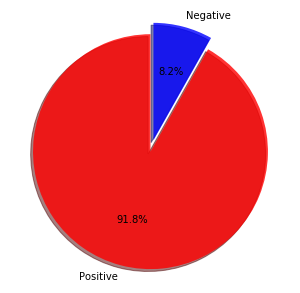

In [25]:
import matplotlib
import matplotlib.pyplot as plt

sizes = [923,82]
explode = (0, 0.1)
labels = 'Positive', 'Negative' 
plt.figure(figsize=(5,5))
plt.pie(sizes, explode=explode, colors="rb", labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, wedgeprops={'alpha':0.8})
plt.axis('equal') 
plt.show()

In [27]:
twt = ['Trump is the worst president ever but the sun is still awesome']
#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=85, dtype='int32', value=0)
sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

negative
